In [19]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Dense, Lambda
from tensorflow.keras.losses import binary_crossentropy, MeanSquaredError
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.backend import reshape

In [20]:
# abrimos pickles de imagenes a color (64,64,3)
y_train_pk = pd.read_pickle("y_train64.pkl")
#y_test = pd.read_pickle("y_test64.pkl")

In [21]:
# abrimos pickles de encaje de texto en gloveB50
file = open('x_train.pkl', 'rb')
x_train_pk = pickle.load(file)
file.close()

#file = open('x_train.pkl', 'rb')
#x_test = pickle.load(file)
#file.close()

In [22]:
x_train = x_train_pk[:,1]
y_train = y_train_pk[:,1]

In [24]:
# Funcion qye convierte a tensores los arreglos de numpy 
# https://www.tensorflow.org/api_docs/python/tf/convert_to_tensor
def my_func(arg):
  arg = tf.convert_to_tensor(arg, dtype=tf.float32)
  return arg

In [25]:
# Convertimos a tensores el encaje de texto 
x_train_tensor = [my_func(x_train[i]) for i in range(len(x_train))]

In [105]:
#x_train = np.array(x_train_tensor)

In [26]:
# convierte a tensores los arreglos de imagenes
y_train_tensor = [my_func(y_train[i]) for i in range(len(x_train))]

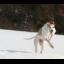

In [27]:
import tensorflow as tf
tf.keras.preprocessing.image.array_to_img(y_train_tensor[40])

In [28]:
class Sampling(layers.Layer):
  """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [29]:
# Encoder
original_inputs = Input(shape=(50,), name='encoder_input')
x = Dense(100, activation='relu')(original_inputs)
z_mean = Dense(150, name='z_mean')(x)
z_log_var = Dense(150, name='z_log_var')(x)
z = Sampling()((z_mean, z_log_var))
encoder = Model(inputs=original_inputs, outputs=z, name='encoder')

# Final encoder
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 50)]         0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 100)          5100        encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 150)          15150       dense_4[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 150)          15150       dense_4[0][0]                    
____________________________________________________________________________________________

In [30]:
# Decoder
latent_inputs = Input(shape=(150,), name='z_sampling')
x = Dense(300, activation='relu')(latent_inputs)
x = Dense(12288, activation='sigmoid')(x)
outputs = reshape(x, shape=(1,64, 64, 3))
decoder = Model(inputs=latent_inputs, outputs=outputs, name='decoder')

# Final encoder
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 150)]             0         
_________________________________________________________________
dense_5 (Dense)              (None, 300)               45300     
_________________________________________________________________
dense_6 (Dense)              (None, 12288)             3698688   
_________________________________________________________________
tf_op_layer_Reshape_1 (Tenso [(1, 64, 64, 3)]          0         
Total params: 3,743,988
Trainable params: 3,743,988
Non-trainable params: 0
_________________________________________________________________


In [31]:
# Modelo VAE
outputs = decoder(z)
vae = Model(inputs=original_inputs, outputs=outputs, name='vae')
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 50)]         0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 100)          5100        encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 150)          15150       dense_4[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 150)          15150       dense_4[0][0]                    
________________________________________________________________________________________________

In [32]:
# Add KL divergence regularization loss.
kl_loss = - 0.5 * tf.reduce_mean(
    z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
vae.add_loss(kl_loss)

In [36]:
x = np.array([x_train[1]])

In [37]:
y = np.array([y_train[1]])

In [38]:
# Train.
optimizer = Adam(learning_rate=1e-3)
vae.compile(optimizer, loss = MeanSquaredError(), metrics=['accuracy'])
vae.fit(x, y, epochs=10, batch_size=32)

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 499ms/sample - loss: 5837.3174 - accuracy: 0.3284
Epoch 2/10
1/1 [==============================] - 0s 12ms/sample - loss: 5830.9658 - accuracy: 0.3447
Epoch 3/10
1/1 [==============================] - 0s 11ms/sample - loss: 5825.1611 - accuracy: 0.3286
Epoch 4/10
1/1 [==============================] - 0s 10ms/sample - loss: 5819.2422 - accuracy: 0.3308
Epoch 5/10
1/1 [==============================] - 0s 15ms/sample - loss: 5808.3423 - accuracy: 0.3252
Epoch 6/10
1/1 [==============================] - 0s 10ms/sample - loss: 5802.8555 - accuracy: 0.3313
Epoch 7/10
1/1 [==============================] - 0s 18ms/sample - loss: 5795.5801 - accuracy: 0.3274
Epoch 8/10
1/1 [==============================] - 0s 10ms/sample - loss: 5788.9780 - accuracy: 0.3289
Epoch 9/10
1/1 [==============================] - 0s 9ms/sample - loss: 5785.9424 - accuracy: 0.3259
Epoch 10/10
1/1 [==============================] - 0s 8ms/sampl

In [39]:
x = np.array([x_train[0],x_train[1]])
y = np.array([y_train[0],y_train[1]])

In [40]:
# Train.
optimizer = Adam(learning_rate=1e-3)
vae.compile(optimizer, loss = MeanSquaredError(), metrics=['accuracy'])
vae.fit(x, y, epochs=10, batch_size=32)

Train on 2 samples
Epoch 1/10
2/2 [==============================] - 1s 261ms/sample


InvalidArgumentError:  Input to reshape is a tensor with 24576 values, but the requested shape has 12288
	 [[node vae/decoder/tf_op_layer_Reshape_1/Reshape_1 (defined at <ipython-input-40-70054b9b9826>:4) ]] [Op:__inference_distributed_function_67272]

Function call stack:
distributed_function
